In [1]:
#Exctrating zero rates from traded data 


#Treasury yields are based on 365/360 day convention 

In [2]:
import numpy as np
import quandl 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('dark_background')
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols
import datetime as dt

In [3]:
quandl.ApiConfig.api_key = "ETVLgt11D2qC12N8pPku" 
today = dt.date.today()
year_ago = today - dt.timedelta(days=365) 
importrates = quandl.get("USTREASURY/YIELD", start_date = year_ago, end_date = today) #Importing data for the last year, assuming 252 trading days
tyields = importrates.drop(['1 MO', '2 MO', '3 MO', '6 MO', '1 YR'], axis=1)

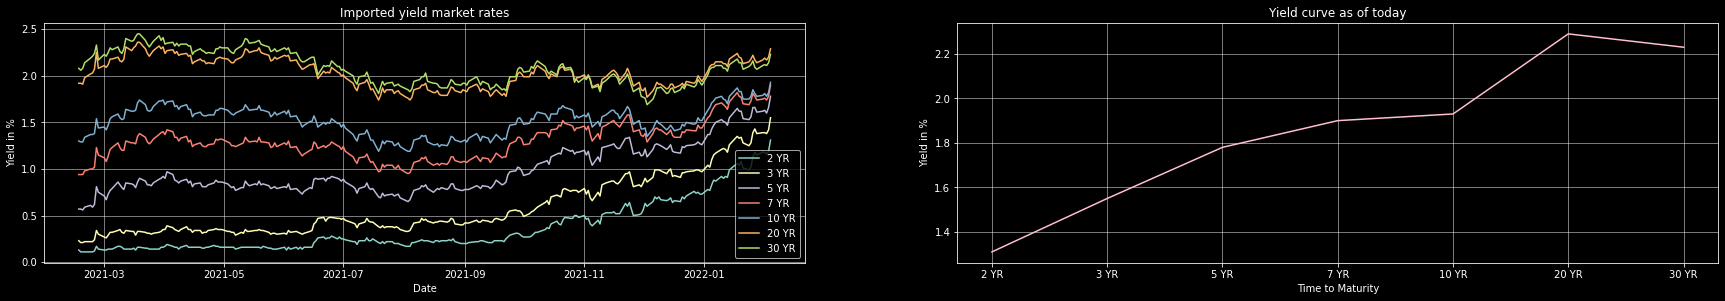

In [4]:
columns = tyields.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(tyields[col])
    plt.xlabel('Date')
    plt.ylabel('Yield in %')
    plt.title('Imported yield market rates')
    plt.grid(alpha = 0.6)
    plt.legend(columns)

plt.subplot(3,2,2)
plt.plot(tyields.iloc[-1], color = 'pink')
plt.ylabel('Yield in %')
plt.xlabel('Time to Maturity')
plt.title('Yield curve as of today')
plt.grid(alpha = 0.6)


In [5]:
# d3a3a61f14441d0538d5bdcdda054aba FRED API 
from fredapi import Fred
fred = Fred(api_key='d3a3a61f14441d0538d5bdcdda054aba')
icerates = pd.DataFrame()
icerates['2 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD2Y', observation_start= year_ago, observation_end=today)
icerates['3 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD3Y', observation_start= year_ago, observation_end=today)
icerates['5 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD5Y', observation_start= year_ago, observation_end=today)
icerates['7 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD7Y', observation_start= year_ago, observation_end=today)
icerates['10 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD10Y', observation_start= year_ago, observation_end=today)
icerates['20 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD20Y', observation_start= year_ago, observation_end=today)
icerates['30 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD30Y', observation_start= year_ago, observation_end=today)
icerates = icerates.dropna()


ValueError: Bad Request.  The series does not exist.

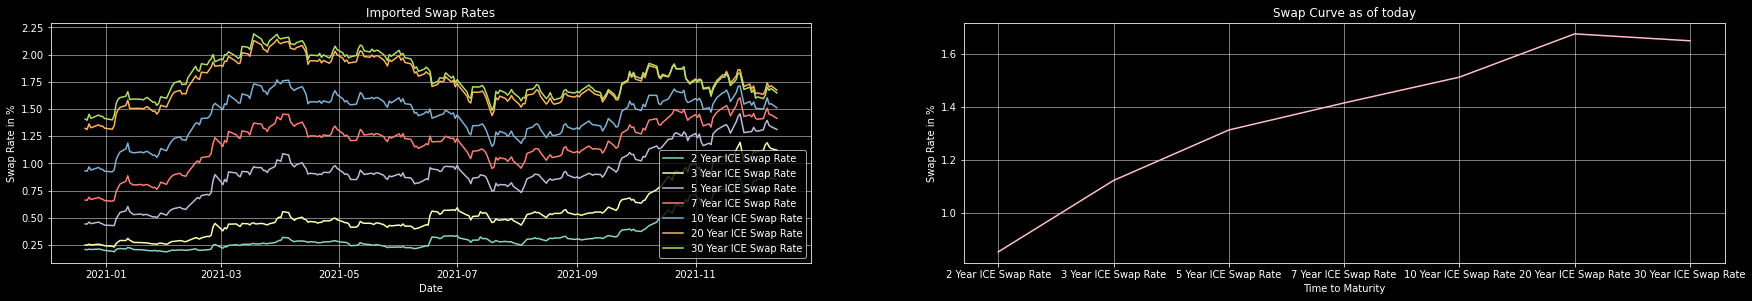

In [ ]:
columns = icerates.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(icerates[col])
    plt.xlabel('Date')
    plt.ylabel('Swap Rate in %')
    plt.title('Imported Swap Rates')
    plt.grid(alpha = 0.6)
    plt.legend(columns)

plt.subplot(3,2,2)
plt.plot(icerates.iloc[-1], color = 'pink')
plt.ylabel('Swap Rate in %')
plt.xlabel('Time to Maturity')
plt.title('Swap Curve as of today')
plt.grid(alpha = 0.6)
plt.show()

In [ ]:
current_market_yields = tyields.iloc[-1].to_numpy()/100
apy = (current_market_yields/2 + 1)**2 - 1

NelsonSiegelSvenssonCurve(beta0=0.022058483400217325, beta1=-0.022270567226985394, beta2=0.0002863668665383477, beta3=-0.008889117082451235, tau1=2.0, tau2=5.0)


Text(0.5, 1.0, 'Nielsen - Siegel - Svenson Model Zero Rates from Market Treasury Yields')

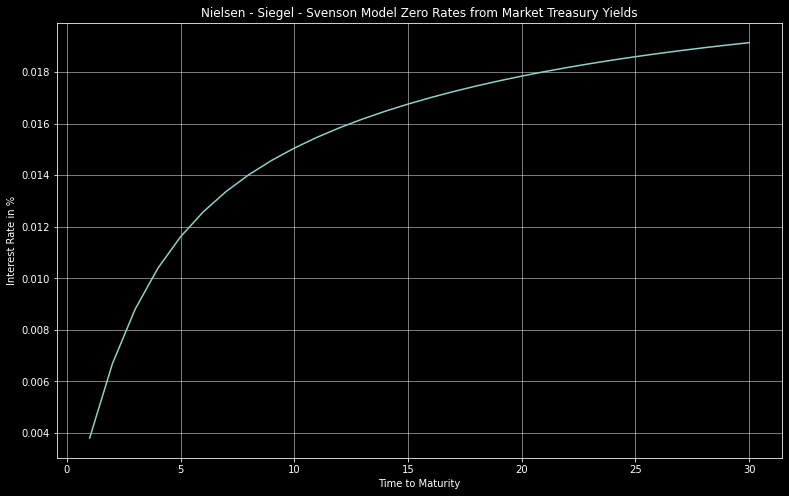

In [ ]:
tenor = np.array([2,3,5,7,10,20,30])
curve, status = calibrate_nss_ols(tenor, current_market_yields)  

NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve,tenor)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve,tenor)
print(curve)

y = NelsonSiegelSvenssonCurve(0.022058483400217325, -0.022270567226985394, 0.0002863668665383477, -0.008889117082451235, 2.0, 5.0)
t = np.arange(1,31,1)

extrapolated_rates = pd.DataFrame()
extrapolated_rates['Time to Maturity'] = t
extrapolated_rates['Extrapolated Rates'] = y(t)
extrapolated_rates = extrapolated_rates.set_index("Time to Maturity")

plt.figure(figsize=(13,8))
plt.plot(extrapolated_rates)
plt.grid(alpha = 0.6)
plt.xlabel('Time to Maturity')
plt.ylabel('Interest Rate in %')
plt.title('Nielsen - Siegel - Svenson Model Zero Rates from Market Treasury Yields')


In [ ]:
NSS_ZC


array([0.00668861, 0.00880269, 0.01161426, 0.01336671, 0.0150493 ,
       0.01784138, 0.01913706])

In [ ]:
y(t)

array([0.00116465, 0.00510329, 0.00794421, 0.01003245, 0.01159787,
       0.012795  , 0.01372878, 0.01447124, 0.0150724 , 0.01556745,
       0.01598147, 0.01633258, 0.01663405, 0.01689578, 0.0171252 ,
       0.01732803, 0.01750869, 0.01767068, 0.01781678, 0.01794922,
       0.01806985, 0.01818017, 0.01828145, 0.01837475, 0.01846096,
       0.01854085, 0.01861508, 0.01868423, 0.01874878, 0.01880918])

In [ ]:
current_swap_rates = icerates.iloc[-1]
def swap_to_zero_df(swap_rates):
    """"
    returns the discount factors from the swap rates
    swap_rates should be provided in decimals
    
    """ 
    bootstrapped_dfs = [1 / (1 + swap_rates[0])]
    for i in swap_rates[1:]:
        bootstrapped_dfs.append((1 - i * sum(bootstrapped_dfs)) / (1+i))  
    return bootstrapped_dfs

bootstrapped_dfs = swap_to_zero_df(current_swap_rates/100)

In [ ]:
current_swap_rates

2 Year ICE Swap Rate     0.853
3 Year ICE Swap Rate     1.122
5 Year ICE Swap Rate     1.312
7 Year ICE Swap Rate     1.414
10 Year ICE Swap Rate    1.511
20 Year ICE Swap Rate    1.674
30 Year ICE Swap Rate    1.648
Name: 2021-12-13 00:00:00, dtype: float64

In [ ]:
zero_cont_rates = []
for x,y in zip(bootstrapped_dfs, tenor): 
    zero_cont_rates.append(-np.log(x)/y)

zero_cont_rates

[0.00424691255946159,
 0.007448324122096144,
 0.007842698140899855,
 0.008052638437195631,
 0.0075351305543970015,
 0.0050215615528764555,
 0.0038379123872975354]